# 8. Seq2seq으로 번역기 만들기

**Seq2seq 기반 번역기를 직접 만들어보며 구조를 이해해 본다. Attention 기법을 추가하여 성능을 높여볼 수 있다. 영어-스페인어 말뭉치와 한국어-영어 말뭉치를 활용해 본다.**

## 8-1. Seq2seq 기반 번역기 만들기

```bash
$ mkdir -p ~/aiffel/s2s_translation
```

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

print("완료!")

완료!


## 8-2. 데이터 전처리

In [2]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

print(tf.__version__)

2.6.0


In [3]:
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip',
    origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

2654208/2638744 [==============================] - 0s 0us/step


In [4]:
with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))
print("Example:")

for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 118964
Example:
>> Go.	Ve.
>> Wait.	Esperen.
>> Hug me.	Abrázame.
>> No way!	¡Ni cagando!
>> Call me.	Llamame.


In [5]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

print("슝~")

슝~


In [6]:
enc_corpus = []
dec_corpus = []

num_examples = 30000

for pair in raw[:num_examples]:
    eng, spa = pair.split("\t")

    enc_corpus.append(preprocess_sentence(eng))
    dec_corpus.append(preprocess_sentence(spa, s_token=True, e_token=True))

print("English:", enc_corpus[100])   # go away !
print("Spanish:", dec_corpus[100])   # <start> salga de aqu ! <end>

English: go away !
Spanish: <start> salga de aqu ! <end>


In [7]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [8]:
# 토큰화하기
enc_tensor, enc_tokenizer = tokenize(enc_corpus)
dec_tensor, dec_tokenizer = tokenize(dec_corpus)

# 훈련 데이터와 검증 데이터로 분리하기
enc_train, enc_val, dec_train, dec_val = \
train_test_split(enc_tensor, dec_tensor, test_size=0.2)

print("English Vocab Size:", len(enc_tokenizer.index_word))
print("Spanish Vocab Size:", len(dec_tokenizer.index_word))

English Vocab Size: 4931
Spanish Vocab Size: 8893


## 8-3. 모델 설계

In [9]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

print("슝~")

슝~


In [10]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

In [11]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [12]:
# 코드를 실행하세요.

BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 30, 1024)
Decoder Output: (64, 8894)
Decoder Hidden State: (64, 1024)
Attention: (64, 30, 1)


## 8-4. 훈련하기 (1) Optimizer & Loss

In [13]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

print("슝~")

슝~


## 8-5. 훈련하기 (2) train_step 구현하기

In [14]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

print("슝~")

슝~


## 8-6. 훈련하기 (3) 훈련 시작하기

In [15]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 10: 100%|██████████| 375/375 [00:44<00:00,  8.40it/s, Loss 0.1400]


In [16]:
# eval_step() 정의하기
# train_step() 이후 eval_step() 진행하도록 소스 수정하기


# Define eval_step

@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]
    
    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))
    
    return batch_loss


# Training Process

from tqdm import tqdm

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    test_loss = 0
    
    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)
    
        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch 10: 100%|██████████| 94/94 [00:04<00:00, 21.76it/s, Test Loss 0.7390]


Input: can i have some coffee ?
Predicted translation: me pueden dar algo ? <end> 


/tmp/ipykernel_50/1426363336.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_50/1426363336.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


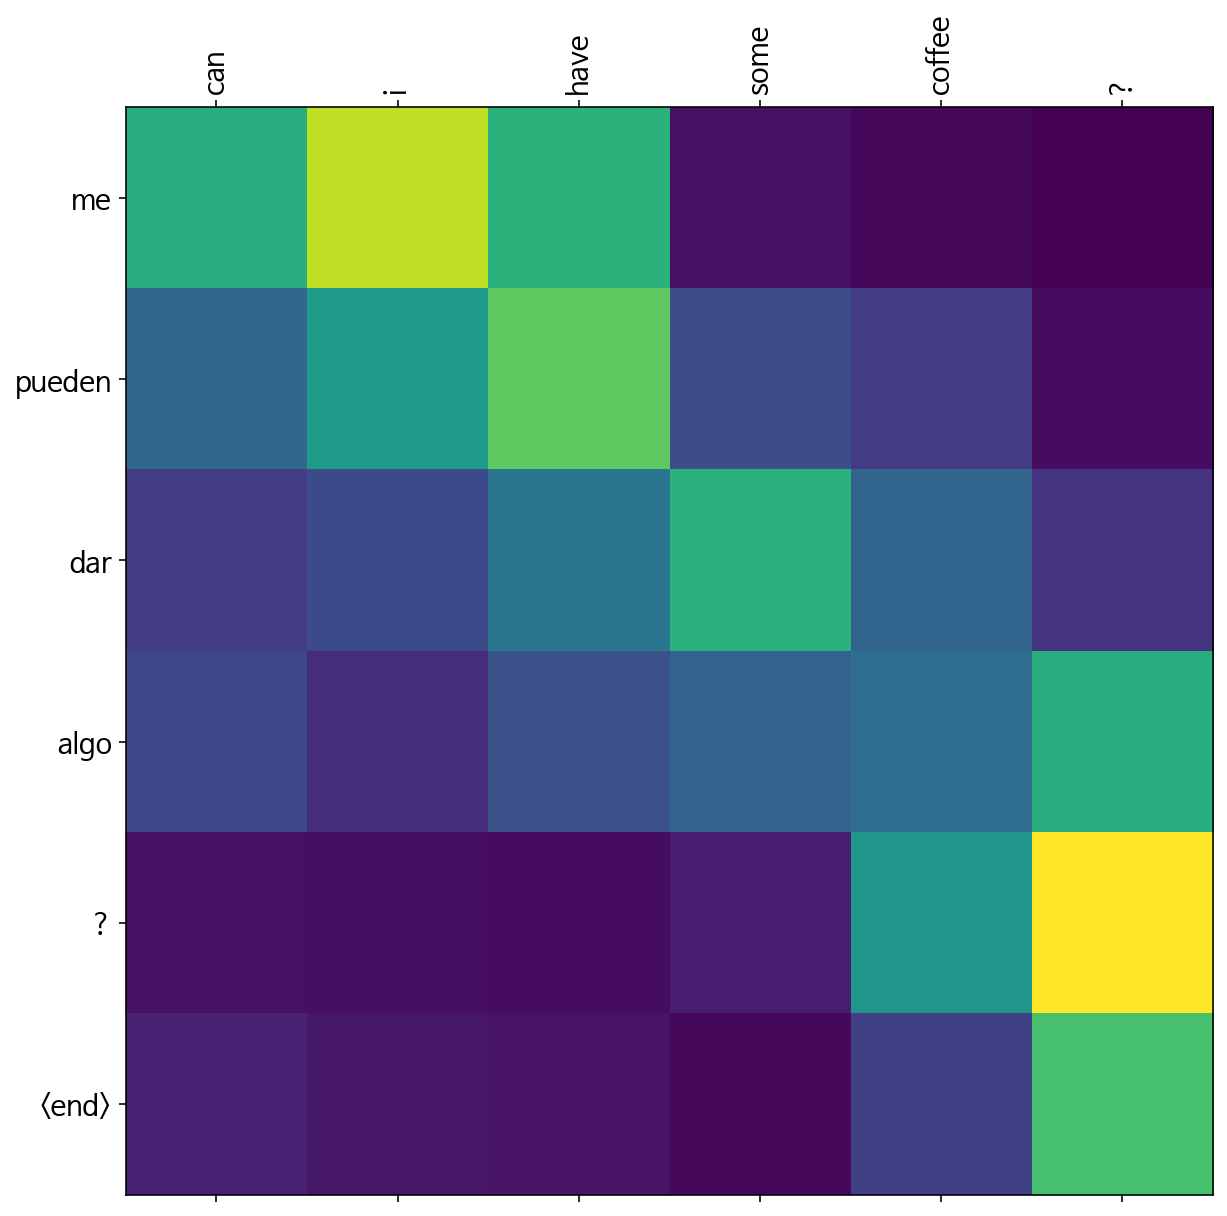

In [17]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))


translate("Can I have some coffee?", encoder, decoder)

## 8-7. 프로젝트: 한영 번역기 만들기

In [18]:
import pandas
import tensorflow
import matplotlib

print(pandas.__version__)
print(tensorflow.__version__)
print(matplotlib.__version__)

1.3.3
2.6.0
3.4.3


>## **루브릭**
>
>|번호|평가문항|상세기준|
>|:---:|---|---|
>|1|번역기 모델 학습에 필요한 텍스트 데이터 전처리가 한국어 포함하여 잘 이루어졌다.|구두점, 대소문자, 띄어쓰기, 한글 형태소분석 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다.|
>|2|Attentional Seq2seq 모델이 정상적으로 구동된다.|seq2seq 모델 훈련 과정에서 training loss가 안정적으로 떨어지면서 학습이 진행됨이 확인되었다.|
>|3|테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.|테스트용 디코더 모델이 정상적으로 만들어져서, 정답과 어느 정도 유사한 영어 번역이 진행됨을 확인하였다.|

In [1]:
import tarfile

# Path to the dataset
dataset_path = "korean-english-park.train.tar.gz"

# Extract the dataset
with tarfile.open(dataset_path, 'r:gz') as tar:
    tar.extractall(path="/aiffel/s2s_translation/")
    
print("슝~")

슝~


In [20]:
import tensorflow as tf
import numpy as np
import time  # Import the time module
import re
import os
import io
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [25]:
import re
from konlpy.tag import Mecab

mecab = Mecab()
# Define preprocessing functions
def preprocess_sentence_kor(sentence):
    mecab = Mecab()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣?.!,]+", " ", sentence)
    sentence = sentence.strip()
    sentence = mecab.morphs(sentence)
    return sentence

def preprocess_sentence_eng(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    if s_token:
        sentence = '<start> ' + sentence
    if e_token:
        sentence += ' <end>'
    return sentence

In [5]:
# Path to the extracted dataset files
data_file_path_en = "/aiffel/s2s_translation/korean-english-park.train.en"
data_file_path_ko = "/aiffel/s2s_translation/korean-english-park.train.ko"

# Read and preprocess the dataset
cleaned_corpus = []
with open(data_file_path_en, 'r', encoding='utf-8') as file_en, open(data_file_path_ko, 'r', encoding='utf-8') as file_ko:
    lines_en = file_en.readlines()
    lines_ko = file_ko.readlines()
    seen = set()
    for eng, kor in zip(lines_en, lines_ko):
        eng = eng.strip()
        kor = kor.strip()
        if (eng, kor) not in seen:
            cleaned_corpus.append((preprocess_sentence_eng(eng, s_token=True, e_token=True), preprocess_sentence_kor(kor)))
            seen.add((eng, kor))

print(f"Cleaned Corpus Size: {len(cleaned_corpus)}")

# Filter sentences with token length greater than 40
eng_corpus = []
kor_corpus = []

for eng, kor in cleaned_corpus:
    if len(eng.split()) <= 40 and len(kor) <= 40:
        eng_corpus.append(eng)
        kor_corpus.append(' '.join(kor))

print(f"English Corpus Size: {len(eng_corpus)}")
print(f"Korean Corpus Size: {len(kor_corpus)}")


Cleaned Corpus Size: 78941
English Corpus Size: 63112
Korean Corpus Size: 63112


In [6]:
import tensorflow as tf

def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    return tensor, tokenizer

# Tokenize the data
input_tensor, inp_lang_tokenizer = tokenize(kor_corpus)
target_tensor, targ_lang_tokenizer = tokenize(eng_corpus)

max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

print(f"Max Length of Target Tensor: {max_length_targ}")
print(f"Max Length of Input Tensor: {max_length_inp}")
print(f"Vocabulary Size of Input Language: {len(inp_lang_tokenizer.word_index)+1}")
print(f"Vocabulary Size of Target Language: {len(targ_lang_tokenizer.word_index)+1}")

Max Length of Target Tensor: 40
Max Length of Input Tensor: 40
Vocabulary Size of Input Language: 37078
Vocabulary Size of Target Language: 38541


In [7]:
BUFFER_SIZE = len(input_tensor)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor) // BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang_tokenizer.word_index) + 1
vocab_tar_size = len(targ_lang_tokenizer.word_index) + 1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor, target_tensor)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape


(TensorShape([64, 40]), TensorShape([64, 40]))

In [15]:
# Define Encoder class
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

# Define Attention class
class Attention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        score = tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

# Define Decoder class
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = Attention(self.dec_units)

    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        return x, state, attention_weights

# Initialize encoder and decoder
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang_tokenizer.word_index) + 1
vocab_tar_size = len(targ_lang_tokenizer.word_index) + 1

encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

# Define optimizer and loss function
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [17]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [18]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [19]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)
        for t in range(1, targ.shape[1]):
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)
            dec_input = tf.expand_dims(targ[:, t], 1)
    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

In [21]:
# Training loop
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))
    print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 5.6221
Epoch 1 Batch 100 Loss 3.7449
Epoch 1 Batch 200 Loss 3.5930
Epoch 1 Batch 300 Loss 3.4687
Epoch 1 Batch 400 Loss 3.3661
Epoch 1 Batch 500 Loss 3.3177
Epoch 1 Batch 600 Loss 3.2817
Epoch 1 Batch 700 Loss 3.2351
Epoch 1 Batch 800 Loss 3.3417
Epoch 1 Batch 900 Loss 3.4654
Epoch 1 Loss 3.5773
Time taken for 1 epoch 672.9268755912781 sec

Epoch 2 Batch 0 Loss 3.2214
Epoch 2 Batch 100 Loss 3.4401
Epoch 2 Batch 200 Loss 3.3326
Epoch 2 Batch 300 Loss 3.0043
Epoch 2 Batch 400 Loss 2.9299
Epoch 2 Batch 500 Loss 2.8697
Epoch 2 Batch 600 Loss 3.0936
Epoch 2 Batch 700 Loss 2.9209
Epoch 2 Batch 800 Loss 3.2065
Epoch 2 Batch 900 Loss 2.9308
Epoch 2 Loss 3.1130
Time taken for 1 epoch 640.9734182357788 sec

Epoch 3 Batch 0 Loss 2.8750
Epoch 3 Batch 100 Loss 2.9528
Epoch 3 Batch 200 Loss 2.9125
Epoch 3 Batch 300 Loss 2.8074
Epoch 3 Batch 400 Loss 2.6851
Epoch 3 Batch 500 Loss 2.9742
Epoch 3 Batch 600 Loss 2.6766


KeyboardInterrupt: 

In [26]:
def evaluate(sentence):
    attention = np.zeros((max_length_targ, max_length_inp))
    sentence = preprocess_sentence_kor(sentence)
    inputs = [inp_lang_tokenizer.word_index[i] for i in mecab.morphs(sentence)]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)
    result = ''
    enc_out, enc_hidden = encoder(inputs, encoder.initialize_hidden_state())
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']], 0)
    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()
        predicted_id = tf.argmax(predictions[0]).numpy()
        result += targ_lang_tokenizer.index_word[predicted_id] + ' '
        if targ_lang_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention
        dec_input = tf.expand_dims([predicted_id], 0)
    return result, sentence, attention

def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    fontdict = {'fontsize': 14}
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

def translate(sentence):
    result, sentence, attention = evaluate(sentence)
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    attention = attention[:len(result.split()), :len(mecab.morphs(sentence))]
    plot_attention(attention, mecab.morphs(sentence), result.split(' '))

translate("오바마는 대통령이다.")


NotImplementedError: Wrong number or type of arguments for overloaded function 'Tagger_parse'.
  Possible C/C++ prototypes are:
    MeCab::Tagger::parse(MeCab::Model const &,MeCab::Lattice *)
    MeCab::Tagger::parse(MeCab::Lattice *) const
    MeCab::Tagger::parse(char const *)


### 예문 ##
K1) 오바마는 대통령이다.
K2) 시민들은 도시 속에 산다.
K3) 커피는 필요 없다.
K4) 일곱 명의 사망자가 발생했다.

### 제출 ##
E1) obama is the president . <end>
E2) people are victims of the city . <end>
E2) the price is not enough . <end>
E2) seven people have died . <end>